# TP1: 

Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Chargement de la base en mémoire

In [2]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist()

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 3


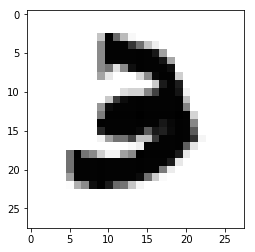

In [3]:
img_id = 900
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

Question 1: Donner les caractéristiques de la base d'apprentissage train_set

In [4]:
def getDimDataset(train_set):
    n_training = len(train_set[1])
    n_feature = len(train_set[0][1])
    n_label = len(np.unique(train_set[1]))
    return n_training, n_feature, n_label

In [5]:
getDimDataset(train_set)

(50000, 784, 10)

## Création du modèle

In [6]:
def init(n_feature,n_label):
    sigma = 1.
    W = np.random.normal(loc=0.0, scale=sigma/np.sqrt(n_feature), size=(n_label,n_feature))
    b = np.zeros((W.shape[0],1))
    return W,b

Question 2: Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [7]:
def printInfo(W,b):
    print("W dimensions: " , W.shape[0], W.shape[1])
    print("b dimensions: " , b.shape[0], b.shape[1])
    print("Number of parameters: " , W.shape[1]*W.shape[0]+b.shape[0])

In [8]:
n_training, n_feature, n_label = getDimDataset(train_set)
W,b = init(n_feature,n_label)
printInfo(W,b)

('W dimensions: ', 10, 784)
('b dimensions: ', 10, 1)
('Number of parameters: ', 7850)


Question 3: Implémenter la fonction forward $$z_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le bias associé à l'unité $j$

In [9]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights
        :param b: the bias
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values
        :rtype: ndarray
    """
    z = W.dot(X.T) + b
    return z

Question 4: Implémenter la fonction softmax $$ \sigma_i = P(t=i|x,W,b) = \frac{\exp{z_i}}{\sum_k \exp{z_k}}$$

In [10]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    return np.exp(z-np.max(z))/np.sum(np.exp(z-np.max(z)))

Optionnel: Vérifier que votre implémentation de softmax soit numériquement stable (cf. http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression)

In [11]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [1000000.0,1.0,100.0]
print(softmax(z))

[ 1.  0.  0.]


Question 5: Implémenter le calcul du gradient de l'erreur par rapport à $z_i$:
$$\delta z_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [12]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z
    :rtype: ndarray
    """
    return out - one_hot_batch

Question 6: Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta z_j x_i$$  $$\delta b_{j} = \delta z_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [13]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z
        :param X: the input (minibatch_size x n_input)
        :param minibatch_size: the minibatch size
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: the gradient w.r.t. the parameters
        :rtype: ndarray, ndarray
    """    
    grad_w = derror.dot(X)/float(len(X))
    grad_b = np.sum(derror)/float(len(X))
    return grad_w,grad_b

Question 7: Implémenter la fonction de mise à jour des paramètres $$p = p - \eta \delta p$$ où $p$ est un paramètre du modèle et $\delta p$ la composante du gradient associée à p.

In [14]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    W = W - eta * grad_w
    b = b - eta * grad_b
    return W, b

Question 8: Implémenter la fonction de calcul du coût et de la précision:
Utiliser les fonction *forward* et *softmax*, puis calculer le coût $c$, qui est moins la log-probabilité des classes à prédire: $$c = - \sum_{(x_{i}, y_{i}) \in \mathcal{D}} \log P(y=y_{i}|x_{i},W,b)$$

Et enfin la précision, c'est à dire le taux de prédictions réussies.

In [101]:
def computeLoss(W, b, batch, labels, softmax):
    """
        Compute the loss value of the current network on the full batch
        :param W: the weights
        :param B: the bias
        :param batch: the weights
        :param labels: label
        :param act_func: the weights
        :type W: ndarray
        :type B: ndarray
        :type batch: ndarray
        :type act_func: function
        :return loss: the negative log-likelihood
        :return accuracy: the ratio of examples that are well-classified
        :rtype: float
        :rtype: float
    """ 
    ### Forward propagation
    ### Compute the softmax
    z = softmax(forward(W,b,batch))
    
    loss = - np.sum(np.log(z[labels , range(batch.shape[0])]))
    
    summ=0
    for j in range(len(labels)):
        summ+=z.T[j,labels[j]]
        
    accuracy = np.sum(labels == np.argmax(z, axis=0))/float(len(labels))
    return summ, accuracy

Question 9: Implémenter la fonction de création de mini-batch, qui pour un indice, une taille de batch, des données d'entraînement et les labels correspondants, renvoie le batch de données/labels correspondant, et la taille du batch. 

In [102]:
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
        Return a minibatch from the training set and the associated labels
        :param i: the identifier of the minibatch
        :param batch_size: the number of training examples
        :param train_set: the training set
        :param one_hot: the one-hot representation of the labels
        :type i: int
        :type batch_size: int
        :type train_set: ndarray
        :type ont_hot: ndarray
        :return: the minibatch of examples
        :return: the minibatch of labels
        :return: the number of examples in the minibatch
        :rtype: ndarray
        :rtype: ndarray
        :rtype: int
    """
    n_training = train_set[0].shape[0]
    idx_begin = i * batch_size
    idx_end = (i+1) * batch_size
    mini_batch_size = batch_size

    batch = train_set[0][idx_begin:idx_end]
    one_hot_batch = one_hot[:, idx_begin:idx_end]

    return np.asfortranarray(batch), one_hot_batch, mini_batch_size

## Algorithme d'apprentissage

In [103]:
import math,time
from IPython.display import clear_output

# Data structures for plotting
g_i = []
g_train_loss=[]
g_train_acc=[]
g_valid_loss=[]
g_valid_acc=[]

n_training, n_feature, n_label = getDimDataset(train_set)

# SGD parameters
eta = 0.001
batch_size = 500
n_batch = int(math.ceil(float(n_training)/batch_size))
n_epoch = 100

cumul_time = 0.

# Initialize the model parameters
W,b = init(n_feature,n_label)
printInfo(W,b)

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

for i in range(n_epoch):
    for j in range(n_batch):

        ### Mini-batch creation
        minibatch, one_hot_batch, minibatch_size = getMiniBatch(j, batch_size, train_set, one_hot)

        prev_time = time.clock()

        ### Forward propagation
        Z = forward(W,b,minibatch)

        ### Compute the softmax
        out = softmax(Z)

        ### Compute the gradient at the top layer
        derror = gradient_out(out,one_hot_batch)

        ### Compute the gradient w.r.t. parameters
        grad_w,grad_b = gradient(derror, minibatch)

        ### Update the parameters
        W,b = update(eta, W, b, grad_w, grad_b)
        
        curr_time = time.clock()
        cumul_time += curr_time - prev_time
    
    ### Training accuracy
    train_loss, train_acc = computeLoss(W, b, train_set[0], train_set[1],softmax) 
    
    ### Valid accuracy
    valid_loss, valid_acc = computeLoss(W, b, valid_set[0], valid_set[1],softmax) 

    g_i = np.append(g_i, i)
    g_train_loss = np.append(g_train_loss, train_loss)
    g_train_acc = np.append(g_train_acc, train_acc)
    g_valid_loss = np.append(g_valid_loss, valid_loss)
    g_valid_acc = np.append(g_valid_acc, valid_acc)
    
    result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_acc) + " " + str(valid_loss) + " " + str(valid_acc) + " " + str(eta)
    print(result_line)

('W dimensions: ', 10, 784)
('b dimensions: ', 10, 1)
('Number of parameters: ', 7850)
0 0.752807000001 0.108986831835 0.16532 0.108521475366 0.1595 0.001
1 1.259696 0.122218689032 0.24904 0.121937796672 0.2497 0.001
2 1.764093 0.138211353694 0.34378 0.137937554699 0.3492 0.001
3 2.270447 0.157752352996 0.41014 0.157161319507 0.4171 0.001
4 2.7744 0.181839053438 0.45306 0.180387556265 0.4623 0.001
5 3.289345 0.211671874137 0.48088 0.208510920484 0.4919 0.001
6 3.862133 0.24856990664 0.5019 0.242462682465 0.515 0.001
7 4.538407 0.293750435029 0.51888 0.283041579191 0.5326 0.001
8 5.199487 0.34792964644 0.53398 0.330641638255 0.5474 0.001
9 6.178305 0.410788308464 0.54606 0.384921163614 0.5599 0.001
10 6.789368 0.480510194937 0.55686 0.444545989425 0.5732 0.001
11 7.306619 0.553733694973 0.56674 0.507193794777 0.5837 0.001
12 7.811557 0.626149595412 0.57524 0.569928038454 0.5921 0.001
13 8.317855 0.693576427299 0.58254 0.629836843898 0.6003 0.001
14 8.92831100001 0.75297325998 0.58832 0.

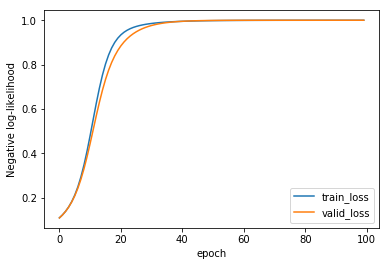

In [104]:
plt.plot(g_i,g_train_loss,label='train_loss')
plt.plot(g_i,g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

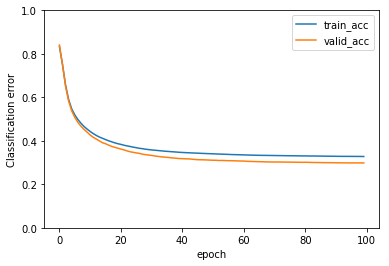

In [105]:
plt.plot(g_i,1.0-g_train_acc,label='train_acc')
plt.plot(g_i,1.0-g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()

Question 10: Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage